In [92]:
%pip install plotly
%pip install sklearn
%pip install scikit-learn
%pip install matplotlib
%pip install seaborn
%pip install pandas


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\maiti\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'




[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\maiti\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\maiti\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\maiti\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\maiti\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [79]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import json
import pandas as pd
from main import count_occurrences, establish_unk_words

# OUT-OF-DOMAIN RESULTS

In [80]:
counts_trains = count_occurrences('UD-Data/out_of_domain/', ['train'], write=False)
counts_dev = count_occurrences('UD-Data/out_of_domain/', ['dev'], write=False)
counts_test = count_occurrences('UD-Data/out_of_domain/', ['test'], write=False)
total_counts = count_occurrences('UD-Data/out_of_domain/', ['train', 'dev', 'test'], write=False)

['UD-Data/out_of_domain//English\\en-ud-tweet-train.conllu']
6711
[]
['UD-Data/out_of_domain//English\\en-ud-tweet-dev.conllu']
3675
[]
['UD-Data/out_of_domain//English\\en-ud-tweet-test.conllu']
5508
[]
['UD-Data/out_of_domain//English\\en-ud-tweet-train.conllu']
['UD-Data/out_of_domain//English\\en-ud-tweet-train.conllu', 'UD-Data/out_of_domain//English\\en-ud-tweet-dev.conllu']
['UD-Data/out_of_domain//English\\en-ud-tweet-train.conllu', 'UD-Data/out_of_domain//English\\en-ud-tweet-dev.conllu', 'UD-Data/out_of_domain//English\\en-ud-tweet-test.conllu']
6711
3675
5508
[]
[]
[]


## ENGLISH


### DATASET ANALYSIS

The Out of Domain English dataset we have chosen is the "Tweebsnk v2" avaliable in this [github](https://github.com/Oneplus/Tweebank/tree/dev). This is a collection of English tweets annotated with POS tags, following the Universal Dependencies. The dataset is already divided in train, dev and test sets. 

In [81]:
dataset_path = "UD-Data/out_of_domain/English/"
def conllu_dict(file_path, i=0):
    with open(file_path, "r", encoding="utf-8") as f:
        tags = []
        sentence = []
        info = {}
        for line in f:
            if line == '\n' and len(tags)!=0:                     
                info[i] = {"tags": tags, "sentence": sentence}
                i+=1
                tags, sentence = [], []
            elif line[0] == '#': pass
            else:
                w_id, word, lemma, tag, _, _, _, tag2, _, _ = line.split('\t')
                sentence.append(word.lower())
                tags.append(tag)
    return info, i

info_train, i = conllu_dict(f'{dataset_path}/en-ud-tweet-train.conllu') 
info_dev, i = conllu_dict(f'{dataset_path}/en-ud-tweet-dev.conllu', i+1) 
info_test, i = conllu_dict(f'{dataset_path}/en-ud-tweet-test.conllu', i+1) 
all_info = {**info_train, **info_dev, **info_test}

Since the corpus could be used as a training dataset, they are divided in 3 files, but here we will analyze it as a single file. The initial division of the sentences and words was the following one:

* en-ud-tweet-train.conllu: 1,639 tweets (24,753 words)
* en-ud-tweet-dev.conllu: 710 tweets (11,742 words)
* en-ud-tweet-test.conllu: 1,201 tweets (19,112 words)

In total there are 3550 sentences or 55607 tagged words. 

In [82]:
train_words = 0
dev_words = 0
test_words = 0
train_lengths = []
dev_lengths = []
test_lengths = []

for doc in info_train.values():
    if isinstance(doc, dict):
        train_lengths.append(len(doc['sentence']))
        train_words += len(doc['sentence'])
for doc in info_dev.values():
    if isinstance(doc, dict):
        dev_lengths.append(len(doc['sentence']))
        dev_words += len(doc['sentence'])
for doc in info_test.values():
    if isinstance(doc, dict):
        test_lengths.append(len(doc['sentence']))
        test_words += len(doc['sentence'])

print("Number of sentences:", len(info_train)+len(info_dev)+len(info_test)-3)
print("Number of words:", test_words + dev_words + train_words)

Number of sentences: 3547
Number of words: 55607


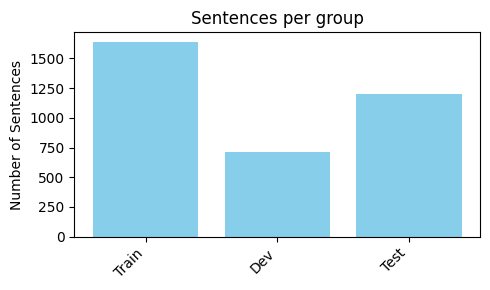

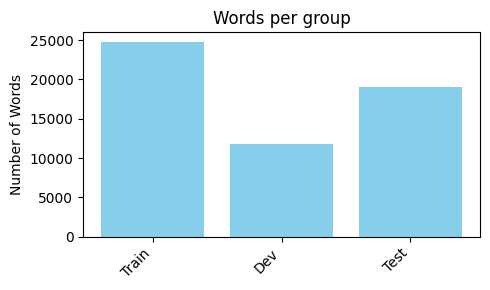

In [83]:
def counts_for_files(files, sentences, counting='Sentences'):    
    plt.figure(figsize=(5, 3))
    plt.bar(files, sentences, color='skyblue')
    plt.ylabel(f'Number of {counting}')
    plt.title(f'{counting} per group')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


counts_for_files(['Train', 'Dev', 'Test'], [len(info_train)-1, len(info_dev)-1, len(info_test)-1])    
counts_for_files(['Train', 'Dev', 'Test'], [train_words, dev_words, test_words], "Words")  

As espected, since it is a Tweeter corpus, the sentence lenght variate from 1 to 40 words, being the mean 15 characters. This can be seen in the boxplots bellow: 

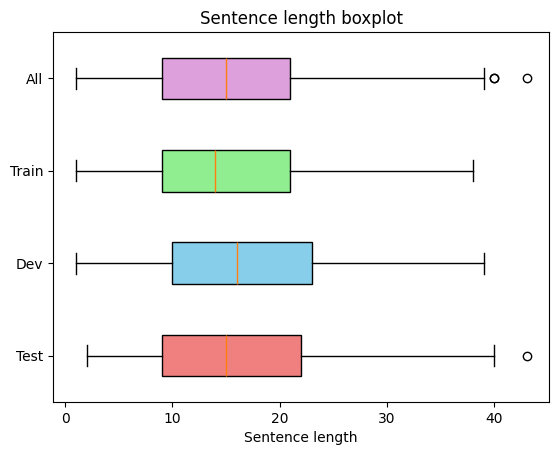

In [84]:
def sentence_length_boxplot(docs, lengths):
    fig, ax = plt.subplots()
    box = ax.boxplot(lengths, vert=False, patch_artist=True)
    colors = ['lightcoral', 'skyblue', 'lightgreen', 'plum']
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    ax.set_yticklabels(docs)
    ax.set_xlabel('Sentence length')
    ax.set_title('Sentence length boxplot')
    plt.show()

sentence_length_boxplot(['Test', 'Dev', 'Train', 'All'], [test_lengths, dev_lengths, train_lengths, train_lengths+dev_lengths+test_lengths])

In [87]:
total_counts

{'English': {'transitions': {'<BOL>, X': 1424,
   'X, X': 2202,
   'X, PUNCT': 1827,
   'PUNCT, ADJ': 283,
   'ADJ, NOUN': 1397,
   'NOUN, PUNCT': 1997,
   'PUNCT, PRON': 908,
   'PRON, AUX': 1354,
   'AUX, AUX': 119,
   'AUX, VERB': 701,
   'VERB, ADP': 930,
   'ADP, NUM': 151,
   'NUM, NOUN': 329,
   'NOUN, CCONJ': 292,
   'CCONJ, ADV': 69,
   'ADV, ADV': 238,
   'ADV, VERB': 453,
   'VERB, DET': 677,
   'DET, NUM': 41,
   'NUM, AUX': 13,
   'AUX, ADV': 325,
   'ADV, PRON': 271,
   'PRON, PUNCT': 394,
   'AUX, DET': 226,
   'DET, NOUN': 1412,
   'PUNCT, PROPN': 719,
   'PROPN, X': 264,
   'PUNCT, <EOL>': 1108,
   'PRON, VERB': 1356,
   'VERB, PROPN': 252,
   'PROPN, PART': 142,
   'PART, VERB': 854,
   'VERB, PRON': 1264,
   'PRON, ADP': 179,
   'ADP, PRON': 646,
   'PRON, PROPN': 65,
   'PROPN, ADP': 205,
   'ADP, DET': 759,
   'NOUN, NOUN': 1027,
   'CCONJ, PRON': 210,
   'VERB, CCONJ': 85,
   'DET, PROPN': 236,
   'PROPN, PUNCT': 756,
   'PUNCT, X': 912,
   'PUNCT, ADV': 351,
   '

2202
1997
1827
912


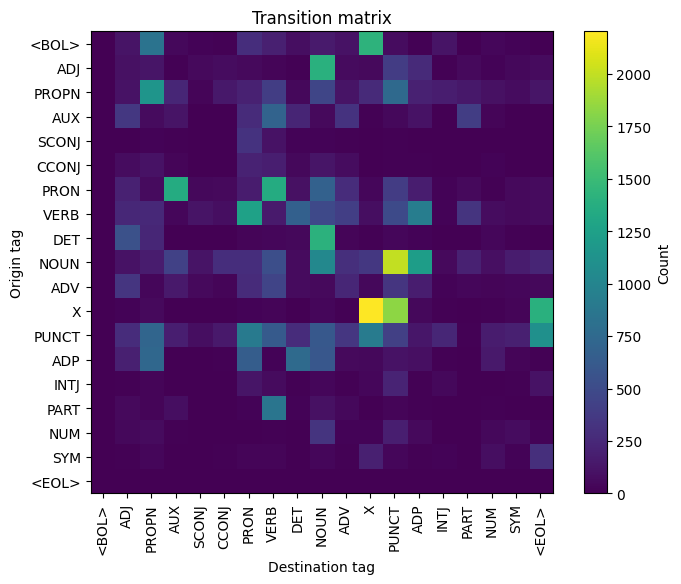

In [106]:
import plotly.express as px
import seaborn as sns
import numpy as np

transitions = total_counts['English']["transitions"]

def get_transition_matrix_and_labels(transitions):
    labels = set()
    for transition in transitions.keys():
        before, after = transition.split(", ")
        labels.add(before)
        labels.add(after)

    # Crear un índice para las etiquetas
    ordered_labels = ["<BOL>"] + [label for label in labels if label != "<BOL>" and label != "<EOL>"] + ["<EOL>"]
    labels = ordered_labels
    label_index = {label: i for i, label in enumerate(labels)}

    # Crear la matriz de transiciones (inicialmente llena de ceros)
    n = len(labels)
    matrix = np.zeros((n, n))

    # Rellenar la matriz con los datos de transiciones
    for transition, count in transitions.items():
        before, after = transition.split(", ")
        i = label_index[before]
        j = label_index[after]
        matrix[i, j] = count
    return matrix, labels

def transition_matrix(transitions):
    matrix, labels = get_transition_matrix_and_labels(transitions)

    plt.figure(figsize=(8, 6))
    cax = plt.imshow(matrix, cmap="viridis", interpolation="nearest")
    plt.colorbar(cax, label="Count")
    plt.xticks(ticks=np.arange(len(labels)), labels=labels, rotation=90)
    plt.yticks(ticks=np.arange(len(labels)), labels=labels)
    plt.title("Transition matrix")
    plt.xlabel("Destination tag")
    plt.ylabel("Origin tag")

transition_matrix(transitions)
print(transitions['X, X'])
print(transitions['NOUN, PUNCT'])
print(transitions['X, PUNCT'])
print(transitions['PUNCT, X'])

### ERROR ANALYSIS

In [3]:
lang = "English"
ruta_archivo = f"output/od_{lang}_predictions.jsonl"

all_tags = []
all_predictions = []

# read de jsonl file and process it
with open(ruta_archivo, "r", encoding="utf-8") as archivo:
    contenido = archivo.read()
    contenido = "[" + contenido.strip().replace("}\n{", "},{") + "]"
    elementos = json.loads(contenido)
    #print(len(elementos[0]))

# get the tag and prediction of each instance and concatenate them
for elemento in elementos:
    all_tags.extend(elemento.get("tags", []))
    all_predictions.extend(elemento.get("prediction", []))

In [4]:
accuracy = accuracy_score(all_tags, all_predictions)
accuracy

0.42317323013885727

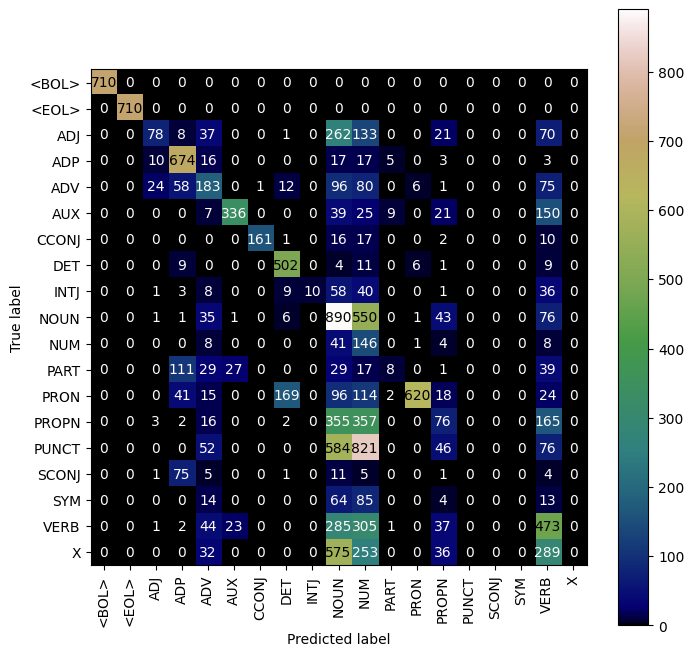

In [7]:
#create the confusion matrix
tags_set = sorted(set(all_tags))
cm = confusion_matrix(all_tags, all_predictions, labels=tags_set)
cm

#show the plot
fig, ax = plt.subplots(figsize=(8, 8))  # Adjust width and height as needed
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tags_set)
disp.plot(cmap="gist_earth", ax=ax, xticks_rotation="vertical")

plt.show()